In [300]:
import numpy as np
import pandas as pd
import re
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

### useful funcs

In [189]:
def find_words(str):
    pattern = r'\b[A-Za-z\']+\b'
    full_words = re.findall(pattern, str)
    return np.array(full_words)

def prop_word(lst_words,word):
    """
    lst of words should be a numpy array
    """
    if sum(lst_words == word) == 0:
        return 0
    full_words, word_count = np.unique(lst_words, return_counts= True)
    index_word = np.argmax(full_words == word)
    return word_count[index_word] / sum(word_count) 

### loading data and feature selection 

In [373]:
#loading in data and getting list of words per record
whole_review_data = pd.read_csv("movie_review.csv",encoding= 'unicode_escape')
whole_review_data['words'] = whole_review_data['Review'].apply(find_words)
whole_review_data

,Review,Polarity,words
0,summer catch ( 2001 ) . starring freddie prinz...,-1,"[summer, catch, starring, freddie, prinze, jr,..."
1,as you should know this summer has been less ...,-1,"[as, you, should, know, this, summer, has, bee..."
2,back in the early years of his career eddie m...,-1,"[back, in, the, early, years, of, his, career,..."
3,the modern use of the western movie and the w...,-1,"[the, modern, use, of, the, western, movie, an..."
4,note : some may consider portions of the follo...,-1,"[note, some, may, consider, portions, of, the,..."
...,...,...,...
1395,member of the 'internet movie critics associat...,1,"[member, of, the, internet, movie, critics, as..."
1396,capsule : what a surprise : a big-name hollywo...,1,"[capsule, what, a, surprise, a, big, name, hol..."
1397,the truman show ( paramount pictures ) running...,1,"[the, truman, show, paramount, pictures, runni..."
1398,by now i figured i'd seen every alfred hitchco...,1,"[by, now, i, figured, i'd, seen, every, alfred..."


In [274]:
#get all positive words 
whole_pos = whole_review_data[whole_review_data["Polarity"] == 1]['words'].to_list()
pos_words = np.array([])
for word_arr in whole_pos:
    unique_lst = list(set(word_arr))
    pos_words = np.append(pos_words, unique_lst)
pos_words_set = set(pos_words)
unique_pos_words, pos_word_count =np.unique(pos_words, return_counts= True)
pos_df = pd.DataFrame({'words': unique_pos_words, 'count': pos_word_count})
pos_df

,words,count
0,'s,88
1,a,695
2,aa,9
3,aaliyah,1
4,aan,2
...,...,...
27655,zwick,5
27656,zwick's,3
27657,zwigoff's,1
27658,zycie,1


In [275]:
#get all negative words
whole_neg = whole_review_data[whole_review_data["Polarity"] == -1]['words'].to_list()
neg_words = np.array([])
for word_arr in whole_neg:
    unique_lst = list(set(word_arr))
    neg_words  = np.append(neg_words , unique_lst)
neg_words_set  = set(neg_words )
unique_neg_words, neg_word_count =np.unique(neg_words, return_counts= True)
neg_df = pd.DataFrame({'words': unique_neg_words, 'count': neg_word_count})
neg_df

,words,count
0,',5
1,'s,91
2,a,696
3,aa,8
4,aaa,1
...,...,...
26066,zul,1
26067,zurrell,1
26068,zwick,1
26069,zwick's,1


In [276]:
only_pos = list(pos_words_set - neg_words_set)
only_neg = list(neg_words_set - pos_words_set)
both_class = list(pos_words_set.union(neg_words_set))
len(only_pos), len(only_neg), len(both_class)

(10952, 9363, 37023)

In [279]:
only_pos_df = pos_df[np.isin(pos_df['words'], only_pos)]
only_pos_df.sort_values(by='count', ascending=False).head()

,words,count
26604,vulnerable,15
110,accessible,11
869,animators,11
22378,sings,11
1378,astounding,10


In [282]:
only_neg_df = neg_df[np.isin(neg_df['words'], only_neg)]
only_neg_df.sort_values(by='count', ascending=False).head()

,words,count
20220,seagal,14
6898,dud,14
15182,muddled,12
24473,unsuspecting,11
8294,feeble,10


In [283]:
#neg df
df_1 = neg_df[np.isin(neg_df['words'], both_class)][(neg_df['count'] >= 20) & (neg_df['count'] <= 40) ]
df_1.rename(columns={'count': 'neg count'}, inplace=True)
#pos df 
df_2 =  pos_df[np.isin(pos_df['words'], both_class)][(pos_df['count'] >= 20) & (pos_df['count'] <= 40) ]
df_2.rename(columns={'count': 'pos count'}, inplace=True)
#both df
both_df = pd.merge(df_1,df_2, on ='words')
both_sorted = both_df[both_df['neg count'] != both_df['pos count']].sort_values(by=['neg count', 'pos count'])

In [289]:
#both_sorted.tail(30)

In [288]:
#both_sorted.head(30)

In [374]:
neg_lst = only_neg_df[only_neg_df['count'] >= 8]['words'].to_numpy()
pos_lst = only_pos_df[only_pos_df['count'] >= 8]['words'].to_numpy()
both_lst = np.array(['love','fun','fact','why','yet','better','think','going','media','ended','episode','fake','baby','pass'])
word_lst = np.append(np.append(neg_lst, pos_lst), both_lst)

In [375]:
for w in word_lst:
    whole_review_data[w] = whole_review_data['words'].apply(prop_word, args=(w,))
ft_df = whole_review_data.iloc[:,3:].to_numpy()
labels = whole_review_data.iloc[:,1].to_numpy()
ft_df.shape

(1400, 54)

### build classifer

In [376]:
#setting up train and test set plus kfold set up
X_train, X_test, y_train, y_test = train_test_split(ft_df, labels, test_size=0.2, random_state=42)
kf = KFold(n_splits=5, shuffle=True, random_state=42)


In [377]:
#pick the best kernel
lst_of_kernel = ['linear', 'poly', 'rbf', 'sigmoid']
avg_scores = []
for k in lst_of_kernel:
    clf = svm.SVC(kernel=k)
    scores = cross_val_score(clf, X_train, y_train, cv=kf, scoring='accuracy')
    avg_scores.append(np.mean(scores))
avg_scores

[0.4892857142857142,
 0.5526785714285715,
 0.6223214285714286,
 0.5830357142857142]

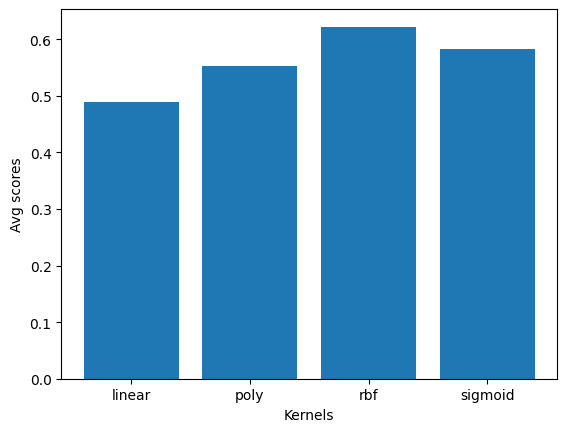

In [378]:
plt.bar(lst_of_kernel, avg_scores)
plt.xlabel('Kernels')
plt.ylabel('Avg scores')
plt.show()

In [379]:
lst_c = [round(10000 * (1/10)**i,3)for i in np.arange(8)]
c_avg_scores = []
for c in lst_c:
    clf = svm.SVC(kernel='rbf', C= c)
    scores = cross_val_score(clf, X_train, y_train, cv=kf, scoring='accuracy')
    c_avg_scores.append(np.mean(scores))
c_avg_scores
    

[0.5875,
 0.60625,
 0.6053571428571429,
 0.6214285714285714,
 0.6223214285714286,
 0.5750000000000001,
 0.4892857142857142,
 0.4892857142857142]

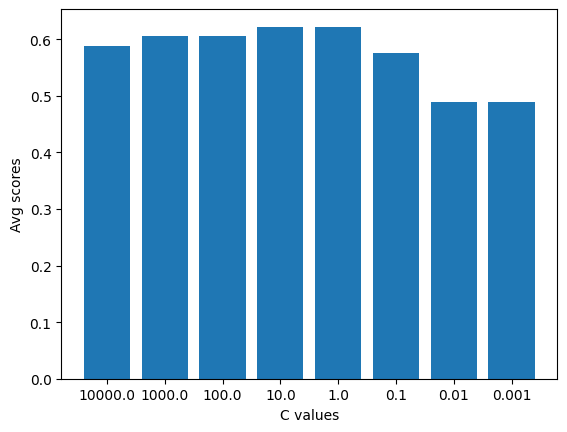

In [380]:
plt.bar([str(i) for i in lst_c], c_avg_scores)
plt.xlabel('C values')
plt.ylabel('Avg scores')
plt.show()

In [381]:
final_clf = svm.SVC(kernel='rbf', C= 10)
final_clf.fit(X_train, y_train)

acc = np.average(final_clf.predict(X_test) == y_test)
acc

0.6